<a href="https://colab.research.google.com/github/Chenghan-Sun/MoA-Prediction/blob/master/notebooks/MoA_NODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment of NEURAL OBLIVIOUS DECISION ENSEMBLES (NODE) on MoA dataset

In [2]:
# !git clone https://github.com/Qwicen/node.git
# !pip install -r node/requirements.txt
# !pip install qhoptim

# only need this one
! pip install iterative-stratification

In [2]:
import datetime
import gc
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import numpy as np
import  os
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import sys
from typing import Optional
from tqdm.notebook import tqdm
from time import time
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import warnings
warnings.filterwarnings("ignore")

Run the following cell if you want to use GDrive (file stored under `/content/drive/MyDrive/Colab Notebooks/MoA-Prediction/moa_data/`.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# path in GDrive
# data_path = "/content/drive/MyDrive/Colab Notebooks/MoA/lish-moa/"

# ------------------ Used when data is in the google drive --------------------#
# path
#!unzip "/content/drive/Shareddrives/moa_data/lish-moa.zip"
#data_path = "/content/"
# -----------------------------------------------------------------------------#

data_file_list = ["train_features.csv", "train_targets_scored.csv"]

# load data
data_train = pd.read_csv(data_path + data_file_list[0])
train_targets_scored = pd.read_csv(data_path + data_file_list[1])

# data info
print(f'Training features file: {data_train.shape[0]} rows; {data_train.shape[1]} columns')
print(f'Training targets scored file: {train_targets_scored.shape[0]} rows; \
{train_targets_scored.shape[1]} columns')

# Train-test split
data_train, data_test, train_targets_scored , test_targets_scored  = train_test_split(data_train, train_targets_scored, test_size = 0.1, random_state = 0)

Training features file: 23814 rows; 876 columns
Training targets scored file: 23814 rows; 207 columns


In [6]:
data_train.head(3)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
3611,id_26c42f465,trt_cp,72,D2,0.2894,0.0080,-3.6110,-0.4329,-0.3965,0.1353,1.0590,-0.0249,2.4480,0.1467,0.0035,-0.1511,1.4710,0.8354,0.0756,-0.2370,-0.6136,1.1260,-1.0050,-0.3086,0.2381,1.2300,0.4391,-0.1009,-0.6560,-0.0124,-0.3104,-0.4918,0.5983,1.092,0.3945,-1.6130,-0.8185,0.5568,-0.0243,2.6580,...,-0.1514,0.7732,-0.1260,-0.3194,0.0879,0.9621,0.1206,1.2350,0.0970,-0.2668,0.2267,-0.3676,-0.2111,-0.136,1.1340,0.2851,0.5577,-0.7656,0.0379,0.6344,-1.2500,-0.5667,1.0420,0.5113,0.1511,-0.1806,-0.8481,0.7934,0.0146,-0.3124,-0.8356,-0.6817,0.3114,0.2517,-0.2191,0.3795,-0.3393,1.2290,0.3202,-0.0692
4827,id_3417d87d0,trt_cp,24,D2,-0.0086,0.7372,0.1810,0.1930,0.5897,-0.3199,-0.5360,0.8846,0.1686,1.0280,-0.2269,-0.1723,-0.0243,-0.3090,-1.0960,-0.1916,-0.3328,0.1532,-0.3413,0.8063,-0.8786,0.7619,-0.4091,-0.4579,2.7620,-0.1528,-0.8778,0.2447,0.0175,-0.402,-1.1290,-0.5179,1.9250,0.0795,0.1999,0.1576,...,-1.4240,0.5922,0.4759,-0.1802,0.1359,0.0685,-0.4201,0.0860,-0.3379,0.8096,-0.8846,0.5055,0.0150,-1.333,-0.1237,1.0710,1.0720,-0.1536,0.2630,0.4629,-0.6015,-0.2448,-0.4243,-0.8581,-0.5474,-0.5817,-0.3486,-0.2435,-0.4311,-0.7990,-1.0190,0.8199,0.0732,-0.2135,-0.9970,-0.5412,0.2128,-0.8640,0.5618,-0.0129
16414,id_b06db0d7e,trt_cp,48,D2,-0.1132,0.0137,0.5486,-0.6832,0.2623,0.7661,0.0703,0.5610,-0.2339,0.5865,-0.6416,-0.5563,-0.5789,-1.0250,-0.0351,0.2711,-0.1328,-1.0150,0.2853,-0.3856,-0.2448,0.1238,0.3049,0.2145,0.2411,-0.6723,0.5567,1.0600,-0.8691,1.018,0.1007,-0.1240,-0.1495,-0.3582,0.0305,0.7547,...,1.1500,-0.1783,0.0298,0.4706,0.1911,-0.3037,-1.0310,0.8685,0.9621,-0.5094,0.8541,-0.0528,0.8923,1.204,-0.4681,1.7920,-0.2205,0.6291,-0.1970,0.2690,1.3110,1.0250,0.2275,-0.3478,0.9035,0.3909,1.6770,-0.2601,0.8882,-0.2747,1.0040,-0.0146,-0.5534,0.7575,0.2705,0.3861,0.5306,0.0786,-0.1251,-0.8556


In [7]:
train_targets_scored.sample(3)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14282,id_99bd16e2d,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12535,id_870c9962c,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21481,id_e6457ea77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
data_train.cp_type.value_counts(normalize=True)

trt_cp         0.921939
ctl_vehicle    0.078061
Name: cp_type, dtype: float64

In [9]:
control_group = data_train.loc[data_train.cp_type == 'ctl_vehicle']
control_group['sig_id'].count()

1673

**Summary**:

7.8357% samples in the original dataset were treated as the control perturbation => 1866 samples out of total sample pool of 23814. In the dataset, cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); Since **control perturbations have no MoAs**, samples (sig_id) with this cp_type will be droped from training. 

# Pre-processing

In [4]:
# Define helper functions data pre-processing
def df_pre_processing(raw_df, type='training', verbose=True):
    # Expand features 2 non-numerical features 'cp_type', 'cp_dose' to 4 dummy 
    # Features based on categorical values 
    processed_df = pd.concat([raw_df, pd.get_dummies(raw_df['cp_dose'], prefix='cp_dose')], axis=1)
    processed_df = pd.concat([processed_df, pd.get_dummies(raw_df['cp_type'], \
                                                                           prefix='cp_type')], axis=1)

    # Drop the three original features
    processed_df = processed_df.drop(['cp_type', 'cp_dose'], axis=1)

    # Removed the samples with wrong cp_type -- removed 1866 samples
    processed_df = processed_df.loc[processed_df['cp_type_trt_cp']==1].reset_index(drop=True)
    
    # Drop the original sig_id column
    processed_df = processed_df.drop(columns='sig_id')

    # Show shape of processed df
    if verbose:
        print(f"Processed {type} dataset shape = {processed_df.shape}.")
        
    return processed_df

# Apply on both training and test dataset
data_train_processed = df_pre_processing(raw_df=data_train)
data_test_processed = df_pre_processing(raw_df=data_test)
data_train_processed.head(3)

Processed training dataset shape = (19759, 877).
Processed training dataset shape = (2189, 877).


,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,cp_dose_D1,cp_dose_D2,cp_type_ctl_vehicle,cp_type_trt_cp
0,72,0.2894,0.0080,-3.6110,-0.4329,-0.3965,0.1353,1.0590,-0.0249,2.4480,0.1467,0.0035,-0.1511,1.4710,0.8354,0.0756,-0.2370,-0.6136,1.1260,-1.0050,-0.3086,0.2381,1.2300,0.4391,-0.1009,-0.6560,-0.0124,-0.3104,-0.4918,0.5983,1.092,0.3945,-1.6130,-0.8185,0.5568,-0.0243,2.6580,0.8234,0.7520,-0.0345,...,0.0879,0.9621,0.1206,1.2350,0.0970,-0.2668,0.2267,-0.3676,-0.2111,-0.136,1.1340,0.2851,0.5577,-0.7656,0.0379,0.6344,-1.2500,-0.5667,1.0420,0.5113,0.1511,-0.1806,-0.8481,0.7934,0.0146,-0.3124,-0.8356,-0.6817,0.3114,0.2517,-0.2191,0.3795,-0.3393,1.2290,0.3202,-0.0692,0,1,0,1
1,24,-0.0086,0.7372,0.1810,0.1930,0.5897,-0.3199,-0.5360,0.8846,0.1686,1.0280,-0.2269,-0.1723,-0.0243,-0.3090,-1.0960,-0.1916,-0.3328,0.1532,-0.3413,0.8063,-0.8786,0.7619,-0.4091,-0.4579,2.7620,-0.1528,-0.8778,0.2447,0.0175,-0.402,-1.1290,-0.5179,1.9250,0.0795,0.1999,0.1576,-3.5680,-0.1497,1.7420,...,0.1359,0.0685,-0.4201,0.0860,-0.3379,0.8096,-0.8846,0.5055,0.0150,-1.333,-0.1237,1.0710,1.0720,-0.1536,0.2630,0.4629,-0.6015,-0.2448,-0.4243,-0.8581,-0.5474,-0.5817,-0.3486,-0.2435,-0.4311,-0.7990,-1.0190,0.8199,0.0732,-0.2135,-0.9970,-0.5412,0.2128,-0.8640,0.5618,-0.0129,0,1,0,1
2,48,-0.1132,0.0137,0.5486,-0.6832,0.2623,0.7661,0.0703,0.5610,-0.2339,0.5865,-0.6416,-0.5563,-0.5789,-1.0250,-0.0351,0.2711,-0.1328,-1.0150,0.2853,-0.3856,-0.2448,0.1238,0.3049,0.2145,0.2411,-0.6723,0.5567,1.0600,-0.8691,1.018,0.1007,-0.1240,-0.1495,-0.3582,0.0305,0.7547,0.3884,0.7555,-0.1698,...,0.1911,-0.3037,-1.0310,0.8685,0.9621,-0.5094,0.8541,-0.0528,0.8923,1.204,-0.4681,1.7920,-0.2205,0.6291,-0.1970,0.2690,1.3110,1.0250,0.2275,-0.3478,0.9035,0.3909,1.6770,-0.2601,0.8882,-0.2747,1.0040,-0.0146,-0.5534,0.7575,0.2705,0.3861,0.5306,0.0786,-0.1251,-0.8556,0,1,0,1


In [5]:
# Define helper functions for traget multi-binary-label classification metric
def metric(y_true, y_pred, df_train_targets):
    metrics = []
    for _target in df_train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels=[0,1]))
    return np.mean(metrics)

def get_average_metrics_out_of_cv_folds(history_list):
    """ Derive total number of folds and total number epochs"""
    total_n_folds = len(history_list)
    total_epochs = len(hist_total_list[0].history['loss'])
    mean_loss = np.zeros([total_n_folds,total_epochs])
    mean_val_loss = np.zeros([total_n_folds,total_epochs])
    
    # Put loss and validation loss in each fold
    for i in range(total_n_folds):
        mean_loss[i,:] = history_list[i].history['loss']
        mean_val_loss[i,:] = history_list[i].history['val_loss']

    # Get average loss and validation loss
    mean_loss = np.mean(mean_loss,axis=0)
    mean_val_loss  = np.mean(mean_val_loss ,axis=0)
    return mean_loss, mean_val_loss

In [6]:
# Removed the samples with wrong cp_type on the training targets scored dataset
train_targets_w_id = train_targets_scored.loc[data_train['cp_type']=='trt_cp'].reset_index(drop=True)
test_targets_w_id = test_targets_scored.loc[data_test['cp_type']=='trt_cp'].reset_index(drop=True)

# Drop the original sig_id column
train_targets = train_targets_w_id.drop(columns='sig_id')
test_targets = test_targets_w_id.drop(columns='sig_id')

print(f"The processed training targets scored data shape = {train_targets.shape}.")
print(f"The processed testing targets scored data shape = {test_targets.shape}.")

The processed training targets scored data shape = (19759, 206).
The processed testing targets scored data shape = (2189, 206).


# Implementation of NODE based on tf.keras framework 

In [7]:
@tf.function
def sparsemoid(inputs: tf.Tensor):
    return tf.clip_by_value(0.5 * inputs + 0.5, 0., 1.)

@tf.function
def identity(x: tf.Tensor):
    return x

class ODST(tf.keras.layers.Layer):
    def __init__(self, n_trees: int = 3, depth: int = 4, units: int = 1, threshold_init_beta: float = 1.):
        super(ODST, self).__init__()
        self.initialized = False
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
    
    def build(self, input_shape: tf.TensorShape):
        feature_selection_logits_init = tf.zeros_initializer()
        self.feature_selection_logits = tf.Variable(initial_value=feature_selection_logits_init(shape=(input_shape[-1], self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)        
        
        feature_thresholds_init = tf.zeros_initializer()
        self.feature_thresholds = tf.Variable(initial_value=feature_thresholds_init(shape=(self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)
        
        log_temperatures_init = tf.ones_initializer()
        self.log_temperatures = tf.Variable(initial_value=log_temperatures_init(shape=(self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)
        
        indices = tf.keras.backend.arange(0, 2 ** self.depth, 1)
        offsets = 2 ** tf.keras.backend.arange(0, self.depth, 1)
        bin_codes = (tf.reshape(indices, (1, -1)) // tf.reshape(offsets, (-1, 1)) % 2)
        bin_codes_1hot = tf.stack([bin_codes, 1 - bin_codes], axis=-1)
        self.bin_codes_1hot = tf.Variable(initial_value=tf.cast(bin_codes_1hot, 'float32'), 
                                          trainable=False)
        
        response_init = tf.ones_initializer()
        self.response = tf.Variable(initial_value=response_init(shape=(self.n_trees, self.units, 2**self.depth), dtype='float32'), 
                                    trainable=True)
                
    def initialize(self, inputs):        
        feature_values = self.feature_values(inputs)
        
        # Intialize feature_thresholds
        percentiles_q = (100 * tfp.distributions.Beta(self.threshold_init_beta, 
                                                      self.threshold_init_beta)
                         .sample([self.n_trees * self.depth]))
        flattened_feature_values = tf.map_fn(tf.keras.backend.flatten, feature_values)
        init_feature_thresholds = tf.linalg.diag_part(tfp.stats.percentile(flattened_feature_values, percentiles_q, axis=0))
        
        self.feature_thresholds.assign(tf.reshape(init_feature_thresholds, self.feature_thresholds.shape))
        
        # Intialize log_temperatures
        self.log_temperatures.assign(tfp.stats.percentile(tf.math.abs(feature_values - self.feature_thresholds), 50, axis=0))
        
    def feature_values(self, inputs: tf.Tensor, training: bool = None):
        feature_selectors = tfa.activations.sparsemax(self.feature_selection_logits)
        # ^--[in_features, n_trees, depth]

        feature_values = tf.einsum('bi,ind->bnd', inputs, feature_selectors)
        # ^--[batch_size, n_trees, depth]
        
        return feature_values
        
    def call(self, inputs: tf.Tensor, training: bool = None):
        if not self.initialized:
            self.initialize(inputs)
            self.initialized = True
            
        feature_values = self.feature_values(inputs)
        
        threshold_logits = (feature_values - self.feature_thresholds) * tf.math.exp(-self.log_temperatures)

        threshold_logits = tf.stack([-threshold_logits, threshold_logits], axis=-1)
        # ^--[batch_size, n_trees, depth, 2]

        bins = sparsemoid(threshold_logits)
        # ^--[batch_size, n_trees, depth, 2], approximately binary

        bin_matches = tf.einsum('btds,dcs->btdc', bins, self.bin_codes_1hot)
        # ^--[batch_size, n_trees, depth, 2 ** depth]

        response_weights = tf.math.reduce_prod(bin_matches, axis=-2)
        # ^-- [batch_size, n_trees, 2 ** depth]

        response = tf.einsum('bnd,ncd->bnc', response_weights, self.response)
        # ^-- [batch_size, n_trees, units]
        
        return tf.reduce_sum(response, axis=1)
        
class NODE(tf.keras.Model):
    def __init__(self, units: int = 1, n_layers: int = 1, output_dim = 1, 
                 dropout_rate = 0.1, link: tf.function = tf.identity, 
                 n_trees: int = 3, depth: int = 4, threshold_init_beta: float = 1., 
                 feature_column: Optional[tf.keras.layers.DenseFeatures] = None):
        super(NODE, self).__init__()
        self.units = units
        self.n_layers = n_layers
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
        self.feature_column = feature_column
        self.dropout_rate = dropout_rate
        self.output_dim = output_dim
        
        if feature_column is None:
            self.feature = tf.keras.layers.Lambda(identity)
        else:
            self.feature = feature_column
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(n_layers + 1)]
        self.dropout = [tf.keras.layers.Dropout(self.dropout_rate) for _ in range(n_layers + 1)]
        self.ensemble = [ODST(n_trees = n_trees,
                              depth = depth,
                              units = units,
                              threshold_init_beta = threshold_init_beta) 
                         for _ in range(n_layers)]
        
        self.last_layer = tf.keras.layers.Dense(self.output_dim)
        
        self.link = link
        
    def call(self, inputs, training=None):
        X = self.feature(inputs)
        X = self.bn[0](X, training=training)
        X = self.dropout[0](X, training=training)
        
        for i, tree in enumerate(self.ensemble):
            H = tree(X)
            X = tf.concat([X, H], axis=1)
            X = self.bn[i + 1](X, training=training)
            X = self.dropout[i + 1](X, training=training)
            
        return self.link(self.last_layer(X))

In [8]:
def compile_NODE(n_layers, units, output_dim, dropout_rate, depth, n_trees, link, learning_rate):
    """ create 
    """ 
    node = NODE(n_layers=n_layers, units=units, output_dim=output_dim, dropout_rate=dropout_rate, 
                depth=depth, n_trees=n_trees, link=tf.keras.activations.sigmoid)
    
    node.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                 loss = 'binary_crossentropy')
    return node

# Train model

In [48]:
# New version of NODE training code
# integrated with K-Fold CV
hist_total_list = []
df_residual = test_targets.copy()
df_residual.loc[:, test_targets.columns] = 0  # reset the residual matrix

# Set global parameters 
N_EXPTS = 3
N_FOLDS = 5
top_feats = np.arange(0,877,1)
#np.load('top_feat.npy') # top_feat.npy is avaiable in submitted data
# If not avaiable, create the full range of index, no difference as the
# full range here

for seed in range(N_EXPTS):
    start_time_seed = time()
    tf.keras.backend.clear_session()  # Clear previous tf session 
    tf.random.set_seed(seed)
    # Stratify the Multilabel K-Folds cross-validator 
    mlsk = MultilabelStratifiedKFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
    mean_loss = 0

    # split training targets based on number of folds 
    for fold, (tr, val) in enumerate(mlsk.split(train_targets, train_targets)):
        start_time_fold = time()  # track time per fold
        x_tr, x_val = data_train_processed.values[tr][:,top_feats], data_train_processed.values[val][:,top_feats]
        y_tr, y_val = train_targets.values[tr][:,:], train_targets.values[val][:,:]
        
        # NODE model instance
        node_model = compile_NODE(n_layers=3, dropout_rate=0.1, depth=3, 
                                  n_trees=3, link=tf.keras.activations.sigmoid, 
                                  learning_rate=1e-3, units=32, output_dim=206)
        # Adaptive alpha, monitor the learning rate and reduce the rate after 3 epochs
        rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                verbose=0, min_delta=1e-4, mode='min')
        # Stop training when val_loss has stopped improving
        es = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, 
                           mode='min', restore_best_weights=True, verbose=0)
        
        # Start fitting NODE model
        history = node_model.fit(x_tr, y_tr, validation_data = (x_val, y_val), 
                                 epochs=15, batch_size=128, callbacks=[rlr,es], verbose=0)
        
        hist_total_list.append(history)
        hist = pd.DataFrame(history.history)
        fold_loss = hist['val_loss'].min()
        mean_loss += fold_loss / N_FOLDS

        # Save predicted prob in residual df
        test_predict = node_model.predict(data_test_processed.values[:,top_feats])
        df_residual.loc[:, test_targets.columns] += test_predict / (N_EXPTS*N_FOLDS)
        print(f'Loss @ Seed {seed}, Fold {fold} = {fold_loss}; time usage = \
        {str(datetime.timedelta(seconds=time()-start_time_fold))[2:7]}')
        
    print(f'Mean loss @ Seed {seed} = {mean_loss}; time usage = \
    {str(datetime.timedelta(seconds=time()-start_time_seed))[2:7]}')

Loss @ Seed 0, Fold 0 = 0.017453033477067947; time usage =         00:40
Loss @ Seed 0, Fold 1 = 0.017454421147704124; time usage =         00:39
Loss @ Seed 0, Fold 2 = 0.01736772246658802; time usage =         00:40
Loss @ Seed 0, Fold 3 = 0.01764039695262909; time usage =         00:40
Loss @ Seed 0, Fold 4 = 0.017568593844771385; time usage =         00:40
Mean loss @ Seed 0 = 0.017496833577752113; time usage =     03:23
Loss @ Seed 1, Fold 0 = 0.0176056157797575; time usage =         00:40
Loss @ Seed 1, Fold 1 = 0.017550772055983543; time usage =         00:40
Loss @ Seed 1, Fold 2 = 0.01737077720463276; time usage =         00:40
Loss @ Seed 1, Fold 3 = 0.01770046539604664; time usage =         00:40
Loss @ Seed 1, Fold 4 = 0.01770775020122528; time usage =         00:39
Mean loss @ Seed 1 = 0.017587076127529144; time usage =     03:22
Loss @ Seed 2, Fold 0 = 0.01755533739924431; time usage =         00:40
Loss @ Seed 2, Fold 1 = 0.017392508685588837; time usage =         00:40


# Evaluate the Model with Testing Set

In [49]:
df_residual.loc[1, test_targets.columns]

print('Test set Predicition Dimension: ', df_residual.shape)
print('Test set Targets Dimension: ', test_targets.shape)

print(f'NODE OOF Metric: {metric(test_targets, df_residual, test_targets)}')

Test set Predicition Dimension:  (2189, 206)
Test set Targets Dimension:  (2189, 206)
NODE OOF Metric: 0.01747743396657329


# Plot Loss and Accuracy vs. Epochs

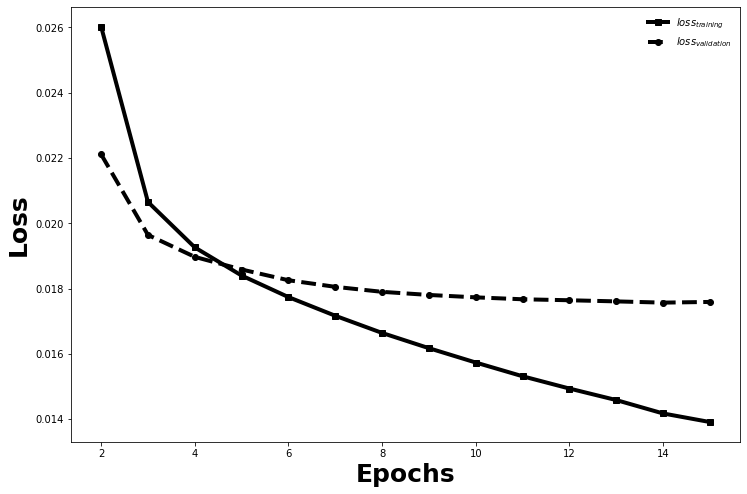

In [50]:
# Get average loss and validation loss out of all folds
mean_loss, mean_val_loss = get_average_metrics_out_of_cv_folds(hist_total_list)
loss_arr = np.vstack([mean_loss, mean_val_loss]).T
np.save('loss_arr_NDOE_with_top_feats.npy', loss_arr)
# Plot Loss and Accuracy vs. Epochs
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1,len(mean_loss)+1,1)[1:],np.array(mean_loss)[1:],'-s',lw=4,label=r'$loss_{training}$',c='k')
plt.plot(np.arange(1,len(mean_val_loss )+1,1)[1:],np.array(mean_val_loss )[1:],'--o',lw=4,label=r'$loss_{validation}$',c='k')
plt.ylabel('Loss',fontsize = 25,fontweight='bold')
plt.xlabel("Epochs",fontsize = 25,fontweight='bold')
plt.legend(loc=1,frameon=False)
plt.show()

# Illustrate Model Summary and Architecture

In [51]:
print('NDOE model summary')
node_model.summary()

NDOE model summary
Model: "node_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            multiple                  0         
_________________________________________________________________
batch_normalization_16 (Batc multiple                  3220      
_________________________________________________________________
batch_normalization_17 (Batc multiple                  3348      
_________________________________________________________________
batch_normalization_18 (Batc multiple                  3476      
_________________________________________________________________
batch_normalization_19 (Batc multiple                  3604      
_________________________________________________________________
dropout_16 (Dropout)         multiple                  0         
_________________________________________________________________
dropout_17 (Dropout)         multiple    